In [39]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

In [40]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.cluster import KMeans
from scipy import integrate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error ,r2_score
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle
import meteomatics.api as api
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, Markdown, clear_output
from numpy import array
from numpy import hstack,vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.metrics import RootMeanSquaredError

# Background
Drone (i.e. quadcopter) ia a promising technology for future last-mile delivery. However, the energy consumption in drones is very inefficient because - unlike conventional aircrafts - they cannot glide to produce lift force. So, they have to cancel their weight along their flight. The energy consumption inefficiency of drones may potentially cause various problems: If the battery charge is not enough, it may lead to unwanted emergency landing which may pose threat to public safety or damage the drone or its cargo. Also, if the charging is excess, that may reduce the battery life over time.
Therefore, it seems that we need to optimize the battery consumption. But, to do that, we should be able to predict the battery consumption and this is the main purpose of this project. 

# Dataset

The dataset used in this study is a collection of recorded variables vs time for a drone test flights. As shown below, it includes both pre-flight (e.g. commanded speed, altitude) and on-flight (e.g. measured velocity components, battery's electrical variables and position):  

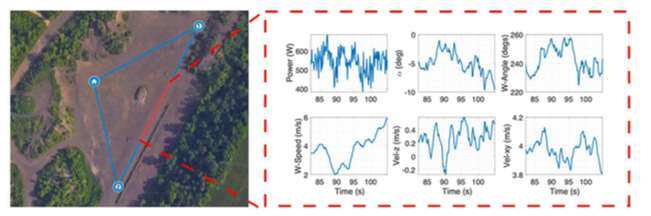

In [79]:
Image('./images/image1.png')

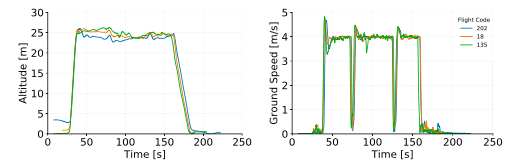

In [80]:
Image('./images/image2.png')


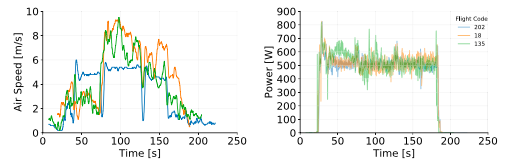

In [81]:
Image('./images/image3.png')

It is observed that the drone flies a triangular route with hovering on each station. Likewise, various data show fluctuations according to different phases of the flight i.e. take-off, hovering, cruise and landing. For example, we see sudden jumps in the power (target variable) during take-off and landing followed by a drop.

I have two approaches for modeling the battery consumption of drone:

1) Identifying various phases of the flight - which were not labeled in the dataset - and use time-averaging to model the power consumed in each of the phases. For this, I use feature engineering and Machine learning
2) modeling time series analysis using deep learning to essentially identify the drone as a system and predict its power consumption over flight time given the flight plan.

I am also developing an app named "Aeolus" which uses these models to predict battery consumption. The raw data and a published paper about it are available, here:

https://kilthub.cmu.edu/articles/dataset/Data_Collected_with_Package_Delivery_Quadcopter_Drone/12683453
https://www.nature.com/articles/s41597-021-00930-x

# Data Cleaning

A sample of the data rows:

In [4]:
df = pd.read_csv('./data/flights.csv')

In [84]:
df.shape

(257896, 28)

In [5]:
df.head(3)

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route
0,1,0.0,0.1,12.0,24.222174,0.087470,-79.782396,40.458047,269.332402,0.001772,...,0.006815,0.004258,-0.120405,-9.811137,4.0,0.0,25,2019-04-07,10:13,R5
1,1,0.2,0.1,3.0,24.227180,0.095421,-79.782396,40.458047,269.332056,0.001768,...,0.002034,0.006175,-0.116397,-9.810392,4.0,0.0,25,2019-04-07,10:13,R5
2,1,0.3,0.1,352.0,24.225929,0.095421,-79.782396,40.458047,269.333081,0.001768,...,-0.000874,0.002696,-0.128592,-9.809440,4.0,0.0,25,2019-04-07,10:13,R5


Data is rather clean and has no missing data:

In [86]:
df.isnull().any().sum()

0

Also, all the columns are numerical except:

In [87]:
df.dtypes[df.dtypes == 'object']

altitude    object
date        object
time_day    object
route       object
dtype: object

Among them, the 'altitude' column is rather strange because it includes both numerical, numerical labeled by string and mixed string data:

In [88]:
df['altitude'].unique()

array([25, 50, 75, 100, 0, 3, '25', '50', '75', '100', '25-50-100-25'],
      dtype=object)

I have seperated the "varying altitude" data and saved the altitude column as integer.

In [6]:
varying_altitude = df['altitude'] == '25-50-100-25'
df_varying_altitude = df[varying_altitude]



In [7]:
df = df[~varying_altitude]
df = df.astype({'altitude':'int'})


Also, "route" column includes various labels:

In [8]:
df['route'].unique()

array(['R5', 'R2', 'R3', 'R4', 'R1', 'A1', 'A2', 'A3', 'H', 'R6'],
      dtype=object)

From the data documentation:
    R1 to R7 = full flights completing a cruise movement;
	A1 = Ancillary ground test with no propellers and no motor movement;
	A2 = Ancillary ground test with no propellers and minimum movement; 
	A3 = Ancillary ground test with propellers and minimum movement;
	H = Hover test with no horizontal movement.  


In [9]:
df[['flight','route']].groupby(by='route').count().reset_index().rename(columns={'flight':'number of data'})

,route,number of data
0,A1,2078
1,A2,1693
2,A3,2730
3,H,3794
4,R1,227551
5,R2,1445
6,R3,1364
7,R4,1197
8,R5,5490
9,R6,8369


So, the largest chunk of data is labeled with R routs and in that "R1" includes most of the data. In R-1 route, the drone completed flight routes with the specified/measred variables (Other R-labeled data are still not clear to me). A-labeled routes are contol tests on the ground (no take-off). H-labeled data are hover flights which may give informaton about wind specifically. I archived R2-6, H and A labeled data separately and consider the R1 data for the study.

In [10]:
control_tests = (df['route'] == 'A1') | (df['route'] == 'A2') | (df['route'] == 'A3')
df_control_tests = df[control_tests]

hover = df['route'] == 'H'
df_hover = df[hover]

R2to6 = df['route'] != 'R1'
df_R2to6 = df[R2to6]

df_main = df[~control_tests & ~hover & ~R2to6]
df_main.to_csv('./data/df_main.csv', index=False)

Finally, I have combined the "date" and "time_day" columns as "datetime". Also, I have defined the "power_consumption" column which includes the target variable:

In [48]:
data = df_main.copy()

data = data.sort_values(by=['flight','time'], ascending=True)


data['datetime'] = data['date'] + ' ' + data['time_day']
data['datetime'] = data['datetime'].apply(lambda t: dt.datetime.strptime(t, '%Y-%m-%d %H:%M'))
data = data.drop(columns=['date', 'time_day', 'route'])

data['power_consumption'] = data['battery_voltage'] * data['battery_current']

data.to_csv('./data/data.csv', index=False)

data.columns

Index(['flight', 'time', 'wind_speed', 'wind_angle', 'battery_voltage',
       'battery_current', 'position_x', 'position_y', 'position_z',
       'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w',
       'velocity_x', 'velocity_y', 'velocity_z', 'angular_x', 'angular_y',
       'angular_z', 'linear_acceleration_x', 'linear_acceleration_y',
       'linear_acceleration_z', 'speed', 'payload', 'altitude', 'datetime',
       'power_consumption'],
      dtype='object')

# Data Exploration

In [49]:
data = pd.read_csv('./data/data.csv')

### To what extent the drone's flight is steady i.e. constant velocity?

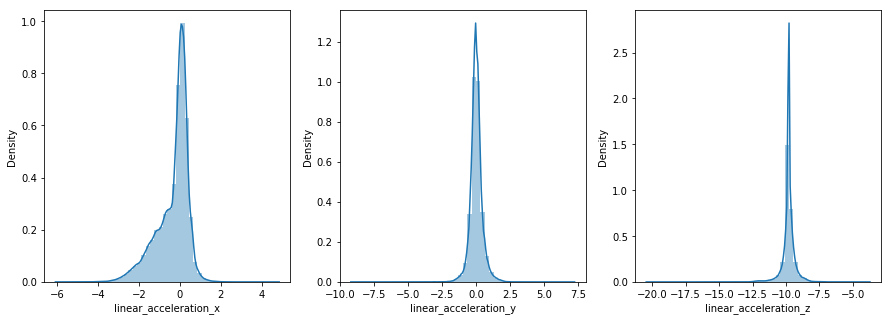

In [50]:
var1, var2, var3= 'linear_acceleration_x', 'linear_acceleration_y','linear_acceleration_z'
plt.subplots(figsize=(15,5))
#plt.axis(y_min=0, y_max=1100)
#plt.xlabel() adjust fontsize
plt.subplot(1,3,1)
sns.distplot(data[var1])
#plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.distplot(data[var2])
plt.subplot(1,3,3)
sns.distplot(data[var3])
#fig = polar plot
#fig.show()

The measured data suggests it is not: while the x- and y-acceleration distributions is centered at zero, z-acceleration is around -10m^2/s suggesting that the drone struggles with gravity throughout its flight.

In [51]:
# how wind compares with API wind
# does wind change at different altitudes

### Wind variables

The "wind_speed" in the paper which is in the raw data is in fact the "Airspeed" i.e. the relative motion of the quadcopter and air, not the absolute movement of air which is wind and this is understandable because the anemometer used to measure is mounted on the quadcopter and is moving with it reletive to air.

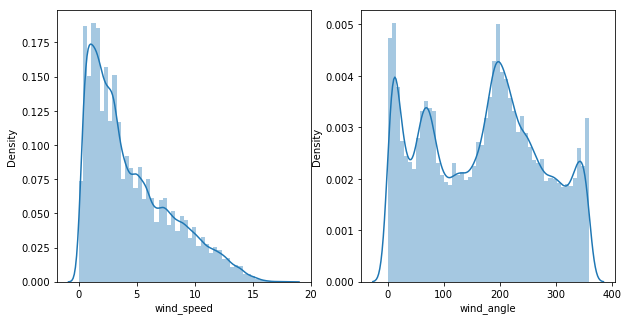

In [52]:

var1, var2= 'wind_speed', 'wind_angle'
plt.subplots(figsize=(10,5))
#plt.axis(y_min=0, y_max=1100)
#plt.xlabel() adjust fontsize
plt.subplot(1,2,1)
sns.distplot(data[var1])
#plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.distplot(data[var2])
#fig = polar plot
#fig.show()

This shows the distribution of the wind variable through the test data. The distribution is not perfect and hardly normal for the "wind_speed" (which is actually Airspeed) and it is not uniform as much as expected for the "wind_angle". The latter can be attributed to the fact that this data is measured reletive to the movement of te drone itself and the drone has moved in certain angles.

### The target variable data and outlier removal

Text(0.5,1,'After Outlier Removal')

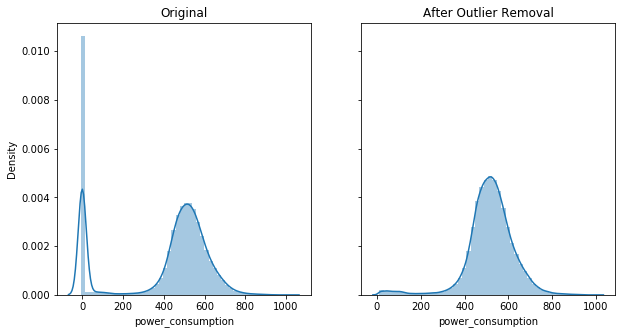

In [53]:


fig, axes = plt.subplots(1,2,figsize=(10,5), sharey=True)
#fig.subtitle('Outlier Removal')
sns.distplot(data['power_consumption'],ax=axes[0])
axes[0].set_title('Original')

low_power_threshold = 10
low_power = data['power_consumption'] < low_power_threshold
#data_low_power = data[low_power]
data=data[~low_power]


sns.distplot(data['power_consumption'],ax=axes[1])
axes[1].set_title('After Outlier Removal')#

The low-power outliers seem to be related to the pre-flight on-ground tests and it's reasonable to be removed. The target variable seems perfectly normal.

# Feature Engineering

We need to add some features to be able to better explain the variance in the target variable. Also, we need to develop the features to discribe wind. Finally, to be able to fully describe the input for the model, we need to have a feature that lables different phases of the flights. 

In [54]:
data['actual_speed'] = (data['velocity_x']**2+data['velocity_y']**2)**0.5
data['tailwind'] = data['actual_speed']- data['wind_speed']*np.sin(data['wind_speed'])*data['velocity_x']/data['actual_speed'] \
                 - data['wind_speed']*np.cos(data['wind_speed'])*data['velocity_y']/data['actual_speed']

data['sidewind'] = abs(data['wind_speed']*np.sin(data['wind_speed'])*data['velocity_x']/data['actual_speed'] \
                 + data['wind_speed']*np.cos(data['wind_speed'])*data['velocity_y']/data['actual_speed'])
#is sine cosine correct?
#are signs correct?
#V_actual must be included?

We extract the "actual_velocity" which is the groundspeed from the kinetic measurements done in the data and used it to extract the abolute wind velocity and then, the wind velocity component on the movement direction of the drone and normal to it i.e. "tailwind" and "sidewind". We consider the absolute value for the "sidewind" but the signed value for the "tailwind". For doing this, we used the "wind_angle" feature which is defined with respect to the north-direction - according to the dataset- considering that the y-coordinate of position is also north direction according to the datese. 

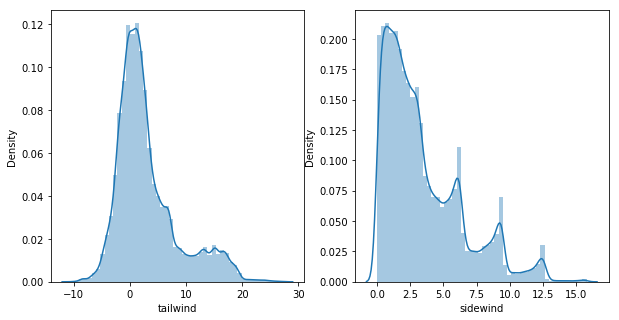

In [55]:

var1, var2= 'tailwind', 'sidewind'
plt.subplots(figsize=(10,5))
#plt.axis(y_min=0, y_max=1100)
#plt.xlabel() adjust fontsize
plt.subplot(1,2,1)
sns.distplot(data[var1])
#plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.distplot(data[var2])
#fig.show()

The distribution are reasonabaly normal around zero. In case of "sidewind", it is half-normal because the absolute value has been considered. 

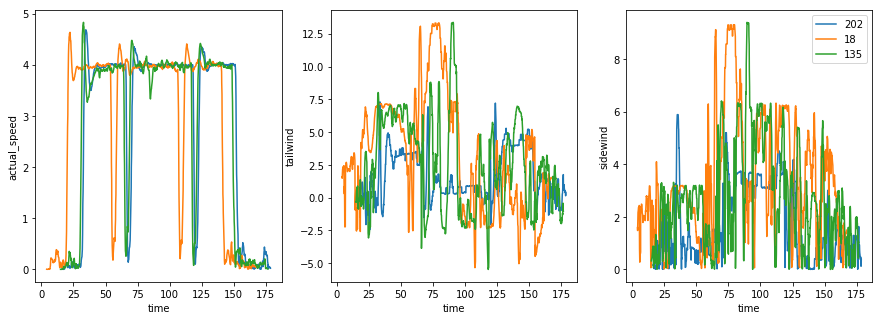

In [57]:
flight = [202, 18, 135]
var1, var2, var3, var4 = 'time', 'actual_speed', 'tailwind', 'sidewind'
plt.subplots(figsize=(15,5))
for num in flight:
    plt.subplot(1,3,1)
    data_plot = data[data['flight']==num]
    sns.lineplot(x=var1, y=var2, data=data_plot)
    plt.subplot(1,3,2)
    data_plot = data[data['flight']==num]
    sns.lineplot(x=var1, y=var3, data=data_plot)
    plt.subplot(1,3,3)
    data_plot = data[data['flight']==num]
    sns.lineplot(x=var1, y=var4, data=data_plot)
plt.legend(labels=['202', '18', '135'])

The first image is a match with the "Ground_Speed" image demonstrated by the paper - except for the a time shift in the data for flight 18. Probabely, not all the flights started at time zero.
The second and third images are wind features. It is observed that these variables are significantly different from the "wind_speed" and are very noisy. However, it appears that during each phase of flight it is constant e.g. looking at the tailwind in the three phases of the cruises in flight 18, it is around 7.5m/s then it goes up to around 12.5 m/s and then it drops to around 0.


In [58]:
#Extract the satellite wind velocity/direction and compare because that is what available pre-flight

The "flight_phase" variables can be extracted considering the difference between the value and signs of different components of the velocity in different phases. I used the ratios of the velocity components to the commanded speed as variables for unsupervised classification for the flight phases: 

In [60]:
km = KMeans(n_clusters=4, n_init=10, random_state=0)
X_flight_phase = np.array([data['velocity_x']/data['speed'], data['velocity_y']/data['speed'],data['velocity_z']/data['speed']]).transpose()
#X_flight_phase = X_flight_phase.to_numpy()
#X_flight_phase = X_flight_phase.reshape(-1, 1)
data['flight_phase'] =  km.fit_predict(X_flight_phase)

In [61]:
# modifying the clusters

flights = data['flight'].unique()

for number in flights:
    
    flight_filter = data['flight']== number
    phase_filter =  data['flight_phase']== 1
    
    time_cruise = data[flight_filter & phase_filter]['time']
    t_start_cruise = min(time_cruise)
    t_end_cruise = max(time_cruise)
    
    phase_filter =  data['flight_phase']== 0
    
    time_filter =  data['time'] <= t_start_cruise 
    idx = data[flight_filter & phase_filter & time_filter]['flight_phase'].index
    data['flight_phase'][idx]=2
    
    time_filter =  data['time'] >= t_end_cruise 
    idx = data[flight_filter & phase_filter & time_filter]['flight_phase'].index
    data['flight_phase'][idx]=3

data['flight_phase'] = data['flight_phase'].replace(0,'hover')
data['flight_phase'] = data['flight_phase'].replace(1,'cruise')
data['flight_phase'] = data['flight_phase'].replace(2,'take_off')
data['flight_phase'] = data['flight_phase'].replace(3,'land')


In [62]:
data['flight_phase'].unique()

array(['take_off', 'cruise', 'hover', 'land'], dtype=object)

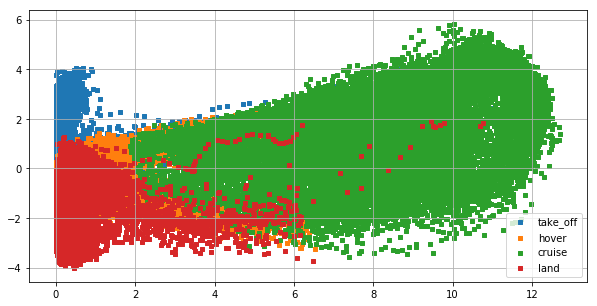

In [63]:

X = data[['velocity_z','actual_speed']].to_numpy()
plt.subplots(figsize=(10,5))
for cluster in set(data['flight_phase']):
    y = X[data['flight_phase'] == cluster,0]
    x = X[data['flight_phase'] == cluster,1]
    plt.scatter(x, y, s=10, marker='s',label= cluster)

plt.legend()
plt.grid()
plt.show()


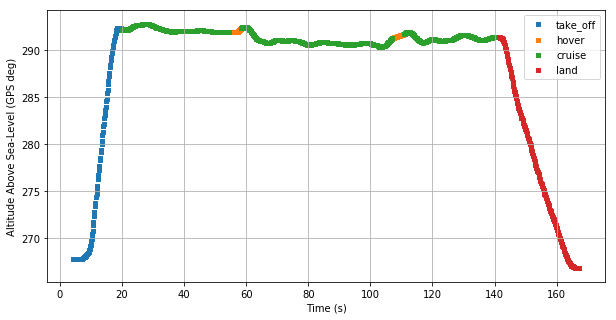

In [64]:
flight_num = 18
data_plot = data[data['flight']==flight_num]
X = data_plot[['time','position_z','flight_phase']].to_numpy()

plt.subplots(figsize=(10,5))
for cluster in set(data_plot['flight_phase']):
    x = X[data_plot['flight_phase'] == cluster,0]
    y = X[data_plot['flight_phase'] == cluster,1]
    plt.scatter(x, y, s=10, marker='s',label= cluster)
    

plt.ylabel('Altitude Above Sea-Level (GPS deg)')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.show()

In [65]:
data.to_csv('./data/data.csv', index=False)

The result shows reasonable labeling of the flight phases. Even the small durations of hovering were identified using the varioables considered for unsupervised classification. We add the flight-phase label as a new feature as a new feature.

We use the flight-phase feature to average all other features over the various phases of the flight and consider only those features that can be used for prediction i.e. can be determined or estimated before the flight:

In [66]:
data = pd.read_csv('./data/data.csv')

data=data.sort_values(by=['flight','time'], ascending=True)


power_consumption = []
speed = []
payload = []
tailwind = []
sidewind = []
flight_phase = []
duration = []
altitude = []
flight =[]

flights = data['flight'].unique()

for number in flights:
    
    flight_filter = data['flight']== number
    flight_phases = data[flight_filter]['flight_phase'].unique()
    
    for cluster in flight_phases:
        
        phase_filter =  data['flight_phase']== cluster
        data_filter = flight_filter & phase_filter
        
        
        t = data[data_filter]['time'].values
        T = max(t)- min(t) #work more on duration Hovering phase!
        
        if cluster == 'hover':
            mid_time = t.mean()
            t1 = max(t[t<mid_time])
            t2 = min(t[t>mid_time])
            T = T -(t2-t1)
        
        V = data[data_filter]['speed'].mean()
        m = data[data_filter]['payload'].mean()
        h = data[data_filter]['altitude'].mean()
        w_t = data[data_filter]['tailwind'].mean() #1/T * integrate.simpson(data[data_filter]['tailwind'], t) #
        w_s = data[data_filter]['sidewind'].mean() #1/T * integrate.simpson(data[data_filter]['sidewind'], t) #
        P =   data[data_filter]['power_consumption'].mean()#1/T * integrate.simpson(data[data_filter]['power_consumption'], t)
        
        flight.append(number)
        flight_phase.append(cluster)
        duration.append(T)
        speed.append(V)
        payload.append(m)
        altitude.append(h)
        tailwind.append(w_t)
        sidewind.append(w_s)
        power_consumption.append(P)
        
        
data_ave = pd.DataFrame()


data_ave['flight']= flight
data_ave['flight_phase']= flight_phase
data_ave['payload']= payload
data_ave['duration']= duration
data_ave['speed']= speed
data_ave['altitude']= altitude
data_ave['tailwind']= tailwind
data_ave['sidewind']= sidewind
data_ave['power_consumption']= power_consumption #power

phase_filter_1 = data_ave['flight_phase']== 'cruise'
phase_filter_2 = data_ave['flight_phase']== 'hover'
data_ave[phase_filter_1]['duration'] -= data_ave[phase_filter_2]['duration']


# check order of time for time integration
# battery usage

In [67]:
data_ave = data_ave.rename(columns={'altitude':'altitude_change'})

phase_filter = (data_ave['flight_phase']=='cruise') | (data_ave['flight_phase']=='hover')
idx = data_ave[phase_filter]['altitude_change'].index
data_ave['altitude_change'][idx]=0

phase_filter = (data_ave['flight_phase']=='hover') | (data_ave['flight_phase']=='take_off') | (data_ave['flight_phase']=='land')
idx = data_ave[phase_filter]['speed'].index
data_ave['speed'][idx]=0

phase_filter = data_ave['flight_phase']=='land'
idx = data_ave[phase_filter]['altitude_change'].index
data_ave['altitude_change'][idx] = - data_ave['altitude_change'][idx]


In [68]:
data_ave.head()

,flight,flight_phase,payload,duration,speed,altitude_change,tailwind,sidewind,power_consumption
0,8,take_off,0.0,16.9,0.0,25.0,0.375296,0.755578,475.118646
1,8,cruise,0.0,121.0,4.0,0.0,3.940941,2.253492,494.523053
2,8,hover,0.0,6.9,0.0,0.0,1.768941,2.297959,551.327921
3,8,land,0.0,25.2,0.0,-25.0,0.450187,1.073100,430.580482
4,10,take_off,0.0,16.1,0.0,25.0,-0.446174,2.330348,478.245298


In [69]:
data_ave.to_csv('./data/data_ave.csv', index=False)

The paper stated that all the flights start and end with constant velocities of take-off and landing. I calculated these velocities using the averaged features. We will use this speed value for the predictor app.

In [73]:
filter_phase = data_ave['flight_phase']=='land'
landing_speed = (data_ave[filter_phase]['altitude_change']/data_ave[filter_phase]['duration']).mean()
print('landing speed:', landing_speed)

filter_phase = data_ave['flight_phase']=='take_off'
take_off_speed = (data_ave[filter_phase]['altitude_change']/data_ave[filter_phase]['duration']).mean()
print('take-off speed:', take_off_speed)


landing speed: -1.272185544117594
take-off speed: 1.8761485668470712


### Averaged target variable

The target variable remains normal after averaging though less populated:

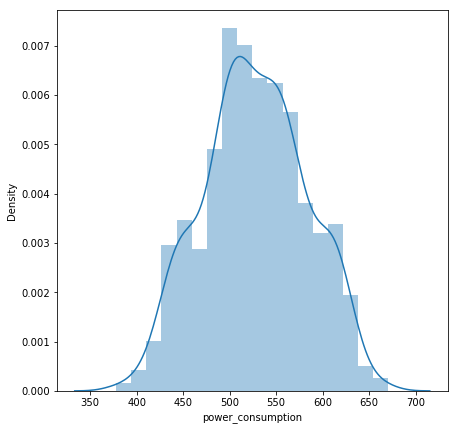

In [30]:
plt.figure(figsize=(7,7))


sns.distplot(data_ave['power_consumption'])
#axes[1].set_title('After,ax=axes[1]')#

### Correlation Study

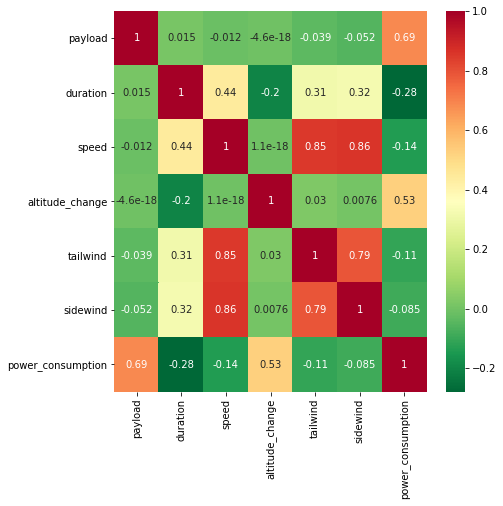

In [31]:
corrmat = data_ave.drop(columns=['flight','flight_phase']) #,'payload','speed','altitude_change'
plt.figure(figsize=(7,7))
g=sns.heatmap(corrmat.corr(),annot=True, cmap='RdYlGn_r')

The target variable shows reletively good correlation with "payload" and "flight_phase". The correlations for the "speed", "tailwind" and "sidewind" are small. The correlation between the features are acceptably low except for wind variables and duration. I omit tailwind and duration for modeling.

### Box-plot Study

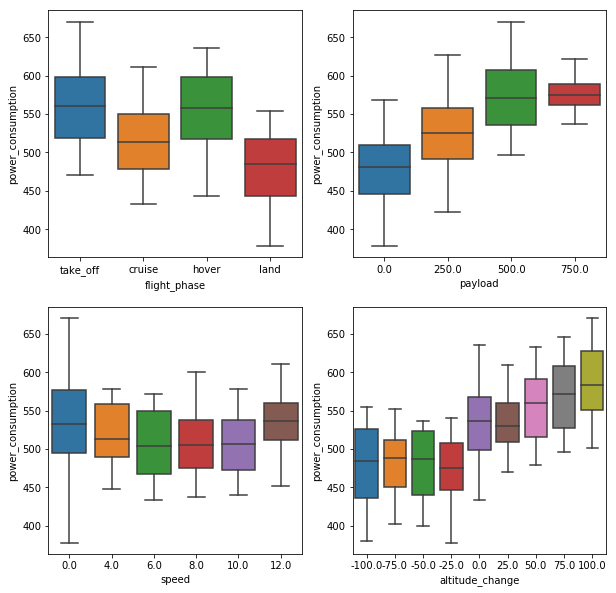

In [32]:
#numerical but not continously sampled
var1, var2, var3, var4= 'flight_phase','payload', 'speed', 'altitude_change'
plt.subplots(figsize=(10,10))
plt.axis(y_min=0, y_max=1100)
#plt.xlabel() adjust fontsize
plt.subplot(2,2,1)
fig = sns.boxplot(x=var1, y='power_consumption', data=data_ave)
#plt.xticks(rotation=90)
plt.subplot(2,2,2)
fig = sns.boxplot(x=var2, y='power_consumption', data=data_ave)
plt.subplot(2,2,3)
fig = sns.boxplot(x=var3, y='power_consumption', data=data_ave)
plt.subplot(2,2,4)
fig = sns.boxplot(x=var4, y='power_consumption', data=data_ave)

These are not discrete or fundamentally categorical data but have been discretely measured/considered so I have dealt with them as categorical data. The categorical features are not imbalanced and are reasonably able to explain the variance in the target variable. 

# Modeling 1: Time-Averaged Machine Learning Model

For modelling, we split flights into train and test sets i.e. all the temporal data for each flight appear either in the train or the test set. We keep "flight" (number) and the "time" as labels but we don't use them in modeling. Once we complete the training, we use the model to predict whole duration of flights in the test data.
For developing the model, we start with the Linear Regression as the baseline model, we add the advanced model(s) and compare and after comparision, we optimise the best model using Grid Search.

In [90]:
data_modeling_1 = data_ave.drop(columns=['flight', 'duration', 'sidewind'])
data_modeling_1.head()

,flight_phase,payload,speed,altitude_change,tailwind,power_consumption
0,take_off,0.0,0.0,25.0,0.375296,475.118646
1,cruise,0.0,4.0,0.0,3.940941,494.523053
2,hover,0.0,0.0,0.0,1.768941,551.327921
3,land,0.0,0.0,-25.0,0.450187,430.580482
4,take_off,0.0,0.0,25.0,-0.446174,478.245298


For modeling, we use Linear Regression as the baseline model, XGBoost as the advanced model and will optimize the model using GridSearch

In [91]:
# Data Preparation

sc = MaxAbsScaler()

X = data_modeling_1.copy()
X = pd.get_dummies(X)
y = X['power_consumption']
X = X.drop(columns=['power_consumption'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=14)

sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)


In [92]:
# adjusted r2
def adj_r2_score(model,y,yhat):
        """Adjusted R square — put fitted linear model, y value, estimated y value in order
        
            Example:
            In [142]: metrics.r2_score(diabetes_y_train,yhat)
            Out[142]: 0.51222621477934993
        
            In [144]: adj_r2_score(lm,diabetes_y_train,yhat)
            Out[144]: 0.50035823946984515"""
        from sklearn import metrics
        adj = 1 - float(len(y)-1)/(len(y)-len(model.coef_)-1)*(1 - metrics.r2_score(y,yhat))
        return adj

In [93]:
reg_baseline = LinearRegression(fit_intercept=True)
reg_advanced = XGBRegressor()

In [94]:
#Baseline Model
reg_baseline.fit(X_train,y_train)
y_pred_baseline = reg_baseline.predict(X_test)
y_pred_baseline_train = reg_baseline.predict(X_train)

In [95]:
#Advanced Model:XGBoost: sequential
reg_advanced.fit(X_train,y_train)
y_pred_advanced = reg_advanced.predict(X_test)
y_pred_advanced_train = reg_advanced.predict(X_train)

### Results

In [104]:
print('Baseline Model:')
r2 = r2_score(y_test,y_pred_baseline)
r2_train = r2_score(y_train,y_pred_baseline_train)
print('R2 Score = ', r2)
print('R2 Score (train) = ', r2_train)
adjusted_r2 = adj_r2_score(reg_baseline,y_test,y_pred_baseline)
adjusted_r2_train = adj_r2_score(reg_baseline,y_train,y_pred_baseline_train)
print('Adjusted R2 Score = ', adjusted_r2)
print('Adjusted R2 Score (train) = ', adjusted_r2_train)
rmse = mean_squared_error(y_test,y_pred_baseline, squared=False)
#rmse_train = mean_squared_error(y_train,y_pred_baseline_train, squared=False)
print('RMSE = ', rmse)
#print('RMSE (train) = ', rmse_train)
print('')
print('Advanced Model:')
r2 = r2_score(y_test,y_pred_advanced)
r2_train = r2_score(y_train,y_pred_advanced_train)
print('R2 Score = ', r2)
print('R2 Score (train) = ', r2_train)
#adjusted_r2 = adj_r2_score(reg_advanced,y_test,y_pred_advanced)
#print('Adjusted R2 Score = ', adjusted_r2)
rmse = mean_squared_error(y_test,y_pred_advanced, squared=False)
#rmse_train = mean_squared_error(y_train,y_pred_advanced_train, squared=False)
print('RMSE = ', rmse)
#print('RMSE (train) = ', rmse_train)


Baseline Model:
R2 Score =  0.8226721413495436
R2 Score (train) =  0.8709315522259015
Adjusted R2 Score =  0.8159167943533356
Adjusted R2 Score (train) =  0.8688664570615159
RMSE =  22.676396095435177

Advanced Model:
R2 Score =  0.8394167608488422
R2 Score (train) =  0.9961602199559996
RMSE =  21.579215714745093


In [106]:
print('Optimized Model:')
xgb = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print('Best Parameters:')
print(xgb_grid.best_params_)




Optimized Model:
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[21:16:19] WARNING: /private/var/folders/wq/gqh6jtdn6v91783c3m6r4v2c0000gn/T/pip-install-7zychkfp/xgboost_8fd69629bc2d4777b10df5c543192839/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:19] WARNING: /private/var/folders/wq/gqh6jtdn6v91783c3m6r4v2c0000gn/T/pip-install-7zychkfp/xgboost_8fd69629bc2d4777b10df5c543192839/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best Parameters:
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthr

In [98]:
reg_best = xgb_grid.best_estimator_
reg_best.fit(X_train,y_train)
y_pred_best = reg_best.predict(X_test)
y_pred_best_train = reg_best.predict(X_train)

[21:03:08] WARNING: /private/var/folders/wq/gqh6jtdn6v91783c3m6r4v2c0000gn/T/pip-install-7zychkfp/xgboost_8fd69629bc2d4777b10df5c543192839/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:03:08] WARNING: /private/var/folders/wq/gqh6jtdn6v91783c3m6r4v2c0000gn/T/pip-install-7zychkfp/xgboost_8fd69629bc2d4777b10df5c543192839/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [99]:
print('Best Model:')
r2 = r2_score(y_test,y_pred_best)
r2_train = r2_score(y_train,y_pred_best_train)
print('R2 Score = ', r2)
print('R2 Score (train) = ', r2)
#adjusted_r2 = adj_r2_score(reg_advanced,y_test,y_pred_advanced)
#print('Adjusted R2 Score = ', adjusted_r2)
rmse = mean_squared_error(y_test,y_pred_best, squared=False)
print('RMSE = ', rmse)

Best Model:
R2 Score =  0.8702999987975653
R2 Score (train) =  0.8702999987975653
RMSE =  19.393470752084966


In [100]:
features = X.columns
feature_importance_values = reg_best.feature_importances_

In [101]:
feature_importance = pd.DataFrame({'features':list(features), 'feature importance':feature_importance_values.tolist()})

The results show clear convergence and no over-fitting.

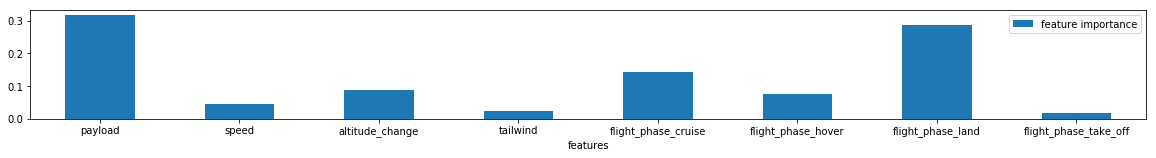

In [102]:
plt.rcParams["figure.figsize"] = (20,2)
ax = feature_importance.plot.bar(x='features', y='feature importance', rot=0)

The feature importance suggests that we may still need to develop more prominant features.

Finally, I have pickled the best model for later use in the predictor app. The app is discussed in separate folder.

In [109]:
X = data_modeling_1.copy()
y = X['power_consumption']
X = X.drop(columns=['power_consumption'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=14)

numeric_transform = Pipeline([('scaling',MaxAbsScaler())])
categorical_transform = Pipeline([('one-hot-encode', OneHotEncoder())])
preprocessing = ColumnTransformer([('numeric', numeric_transform,['payload', 'speed',
                                                                  'altitude_change','tailwind']),
                                   ('categorical', categorical_transform, ['flight_phase'])])
modeling_pipeline = Pipeline([('preprocessing',preprocessing),
                    ('model', XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.03,
                                           max_depth = 7, min_child_weight = 4, n_estimators =500,
                                           nthread =4, objective= 'reg:linear', silent = 1, subsample=0.7))])
modeling_pipeline.fit(X_train,y_train)

with open('./app/Aeolus_Predictor.pickle', 'wb') as f:
    pickle.dump(modeling_pipeline, f)

[21:35:17] WARNING: /private/var/folders/wq/gqh6jtdn6v91783c3m6r4v2c0000gn/T/pip-install-7zychkfp/xgboost_8fd69629bc2d4777b10df5c543192839/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:35:17] WARNING: /private/var/folders/wq/gqh6jtdn6v91783c3m6r4v2c0000gn/T/pip-install-7zychkfp/xgboost_8fd69629bc2d4777b10df5c543192839/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




# Modeling 2: Time-Series Deep Learning Model 

I use LSTM deep learning model to study parallel multi-variate time series describing the kinetics and power consumption of drone. (This part will be getting updated)   

In [205]:
# main model: LSTM
data_modeling_2 = pd.read_csv('./data/data.csv')

In [206]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, 6:]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [207]:
flights = data_modeling_2['flight'].unique()
n_flights = len(flights)
indices = np.random.choice(np.arange(flights.size), replace=False,
                           size=int(flights.size * 0.1))
simulation_flights = flights[indices]
flights = np.delete(flights, indices)

In [208]:
selected_features = ['time','speed', 'payload', 'altitude','wind_speed', 'wind_angle', 'velocity_x', 'velocity_y', 'velocity_z','power_consumption']

sc = MaxAbsScaler()
sc.fit(data_modeling_2[selected_features])


MaxAbsScaler()

In [209]:
empty = True
n_steps = 3
 #6
X=[]
y=[]
for number in flights:
    flight_filter = data_modeling_2['flight']==number
    flight_data = data_modeling_2[flight_filter][selected_features]
    dataset = sc.transform(flight_data)
    #dataset = flight_data.to_numpy()
    X0, y0 = split_sequences(dataset, n_steps)
    if not(empty):
        X=vstack((X,X0))
        y=vstack((y,y0))
    else:
        X=X0
        y=y0
        empty = False
        
            

   
    

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=43)

In [225]:
n_features = X.shape[2] 
n_out = y.shape[1]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_out))
model.compile(optimizer='adam', loss='mse')


In [226]:
# fit model
history_train = model.fit(X_train, y_train, epochs = 10, batch_size = 500) 
  

Epoch 1/10
228/228 [==============================] - 11s 39ms/step - loss: 0.0121
Epoch 2/10
228/228 [==============================] - 9s 38ms/step - loss: 0.0012
Epoch 3/10
228/228 [==============================] - 8s 37ms/step - loss: 9.6177e-04
Epoch 4/10
228/228 [==============================] - 9s 38ms/step - loss: 8.0769e-04
Epoch 5/10
228/228 [==============================] - 9s 41ms/step - loss: 7.3870e-04
Epoch 6/10
228/228 [==============================] - 14s 61ms/step - loss: 7.0738e-04
Epoch 7/10
228/228 [==============================] - 9s 39ms/step - loss: 6.9333e-04
Epoch 8/10
228/228 [==============================] - 13s 59ms/step - loss: 6.8120e-04
Epoch 9/10
228/228 [==============================] - 9s 38ms/step - loss: 6.7671e-04
Epoch 10/10
228/228 [==============================] - 9s 39ms/step - loss: 6.6791e-04


In [227]:
train_loss= model.evaluate(X_train, y_train)
print('train_loss', train_loss)
test_loss = model.evaluate(X_test, y_test)
print('test_loss', test_loss)

3549/3549 [==============================] - 10s 3ms/step - loss: 6.5402e-04
train_loss 0.0006540201720781624
1521/1521 [==============================] - 4s 3ms/step - loss: 6.4719e-04
test_loss 0.0006471869419328868


# Optimization of Flight Parameters

This part will be updated...

In [ ]:
#Optimization
#def predict_battery_usage(x):
#    speed,altitude = x[0], x[1]
#    duration_takeoff = altitude/1.8761485668470712
#    flight_plan.iloc[0,2] = duration_takeoff
#    duration_cruise = distance/speed
#    flight_plan.iloc[1,2] = duration_cruise
#    duration_land = altitude/1.272185544117594
#    flight_plan.iloc[2,2] = duration_land
#    flight_plan.iloc[0,4] = altitude
#    flight_plan.iloc[2,4] = -altitude
#    power_consumption = modeling_pipeline.predict(flight_plan)
#    duration = flight_plan['duration']
#    battery_usage = power_consumption.dot(duration)/3600
#    return battery_usage
#x0 = np.array([altitude, speed])
#from scipy.optimize import Bounds
#bounds = Bounds([25, 4], [100, 10])
#res = minimize(predict_battery_usage, x0, method='trust-constr', options={'verbose': 1}, bounds=bounds)
#res.x